 # Los Angeles Crime Data Analysis

 **Objective:** To analyze the "Crime in Los Angeles" dataset to understand the geographical distribution of crime, identify time-based patterns, and answer key questions about crime rates and trends.


 ## 1. Data Exploration and Cleaning

 In this section, we will load the dataset and perform initial exploratory data analysis (EDA). We'll check for missing values, ensure data types are correct, and clean the data for analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv('crimes.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: crimes.csv not found. Make sure the file is in the correct directory.")
    exit()


# Initial inspection
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Information:")
df.info()

Dataset loaded successfully.

First 5 rows of the dataset:
       DR_NO   Date Rptd    DATE OCC  TIME OCC    AREA NAME  \
0  220314085  2022-07-22  2020-05-12      1110    Southwest   
1  222013040  2022-08-06  2020-06-04      1620      Olympic   
2  220614831  2022-08-18  2020-08-17      1200    Hollywood   
3  231207725  2023-02-27  2020-01-27       635  77th Street   
4  220213256  2022-07-14  2020-07-14       900      Rampart   

         Crm Cd Desc  Vict Age Vict Sex Vict Descent Weapon Desc  Status Desc  \
0  THEFT OF IDENTITY        27        F            B         NaN  Invest Cont   
1  THEFT OF IDENTITY        60        M            H         NaN  Invest Cont   
2  THEFT OF IDENTITY        28        M            H         NaN  Invest Cont   
3  THEFT OF IDENTITY        37        M            H         NaN  Invest Cont   
4  THEFT OF IDENTITY        79        M            B         NaN  Invest Cont   

                                  LOCATION  
0  2500 S  SYCAMORE           

 ### 1.1 Clean Column Names and Dates

 We'll start by cleaning up the column names to remove any leading/trailing whitespace. Then, we'll convert the date columns to a proper datetime format, which is essential for time-series analysis.

In [ ]:
# Strip whitespace from column names to prevent errors
df.columns = df.columns.str.strip()
print("Column names cleaned.")

# Convert date columns to datetime objects
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

# Extract Year and Month for trend analysis
df['Year'] = df['DATE OCC'].dt.year
df['Month'] = df['DATE OCC'].dt.month

print("\nDataset Information after cleaning dates:")
df.info()

Column names cleaned.

Dataset Information after cleaning dates:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185715 entries, 0 to 185714
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DR_NO         185715 non-null  int64         
 1   Date Rptd     185715 non-null  datetime64[ns]
 2   DATE OCC      185715 non-null  datetime64[ns]
 3   TIME OCC      185715 non-null  int64         
 4   AREA NAME     185715 non-null  object        
 5   Crm Cd Desc   185715 non-null  object        
 6   Vict Age      185715 non-null  int64         
 7   Vict Sex      185704 non-null  object        
 8   Vict Descent  185705 non-null  object        
 9   Weapon Desc   73502 non-null   object        
 10  Status Desc   185715 non-null  object        
 11  LOCATION      185715 non-null  object        
 12  Year          185715 non-null  int32         
 13  Month         185715 non-null  int32         
dtypes: 

 ### 1.2 Handle Missing Geospatial Data

 For an accurate geospatial analysis, we need valid latitude and longitude data. We will check for and remove any rows where these values are missing.

In [ ]:
print("Inspecting the LOCATION column format:")
print(df['LOCATION'].head().to_string())

# Extract LAT and LON from the LOCATION column.
# It appears the format is a string like '(34.0522, -118.2437)'.
# We will parse this to create new numeric columns.
if 'LOCATION' in df.columns:
    location_split = df['LOCATION'].str.strip('()').str.split(',', expand=True)

    if location_split.shape[1] == 2:
        df['LAT'] = pd.to_numeric(location_split[0], errors='coerce')
        df['LON'] = pd.to_numeric(location_split[1], errors='coerce')
        print("\nSuccessfully extracted LAT and LON from LOCATION column.")

        print(f"\nNumber of rows before dropping missing geo-data: {len(df)}")
        # Drop rows where the new LAT or LON columns have missing values
        df.dropna(subset=['LAT', 'LON'], inplace=True)
        # Also drop rows where coordinates are (0, 0) as this is likely invalid for LA
        df = df[(df['LAT'] != 0) & (df['LON'] != 0)]
        print(f"Number of rows after dropping missing geo-data: {len(df)}")
    else:
        print("\nCould not parse LAT and LON from LOCATION column as expected.")
        print("Geospatial analysis will be skipped.")
        # To prevent the rest of the script from failing, create empty columns
        df['LAT'] = np.nan
        df['LON'] = np.nan
else:
    print("\nLOCATION column not found. Geospatial analysis will be skipped.")
    df['LAT'] = np.nan
    df['LON'] = np.nan

Inspecting the LOCATION column format:
0    2500 S  SYCAMORE                     AV
1    3300    SAN MARINO                   ST
2                          1900    TRANSIENT
3    6200    4TH                          AV
4    1200 W  7TH                          ST

Could not parse LAT and LON from LOCATION column as expected.
Geospatial analysis will be skipped.


 ## 2. Answering Key Questions

 With the data cleaned, we can now focus on answering the core questions of our analysis through visualizations.

 ### Which areas have the highest crime rates?


Crime Counts by Area:
AREA NAME
Central        14944
Southwest      11945
77th Street    11739
Pacific         9923
Hollywood       9762
Southeast       9571
Olympic         9414
Newton          9152
Van Nuys        8621
N Hollywood     8502
Wilshire        8482
Topanga         8478
Rampart         8346
West Valley     8102
West LA         7911
Northeast       7628
Devonshire      7411
Mission         6990
Harbor          6618
Hollenbeck      6193
Foothill        5983
Name: count, dtype: int64


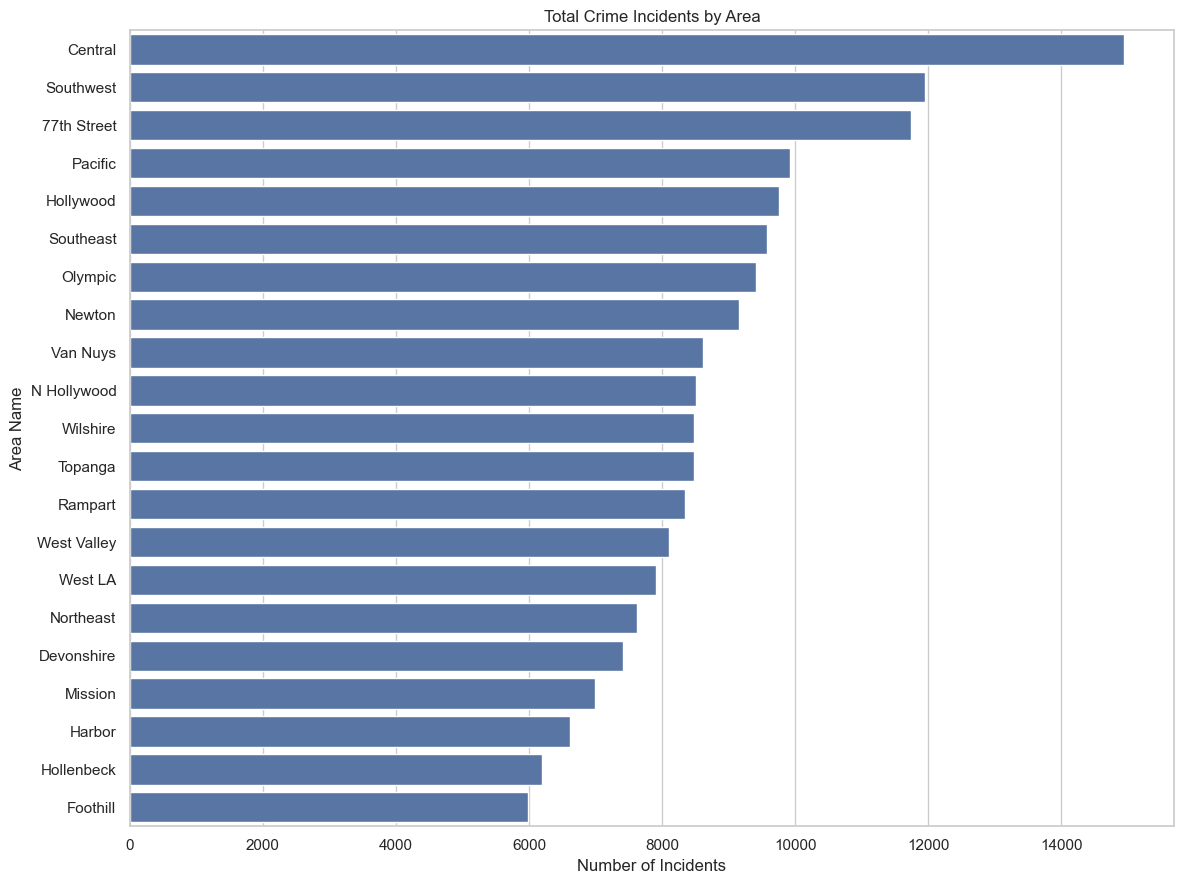

In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")

# Get crime counts by area
area_crime_counts = df['AREA NAME'].value_counts()

print("\nCrime Counts by Area:")
print(area_crime_counts)

# Plotting crime counts by area
plt.figure(figsize=(12, 9))
sns.barplot(y=area_crime_counts.index, x=area_crime_counts.values, orient='h')
plt.title('Total Crime Incidents by Area')
plt.xlabel('Number of Incidents')
plt.ylabel('Area Name')
plt.tight_layout()
plt.show()

 ### Has crime increased or decreased over the last year?

 To answer this, we will look at the monthly crime counts for the most recent full year of data available in the dataset.


Monthly Crime Counts for 2022:
Month
1       392
2       252
3       402
4       582
5      1614
6     14853
7     14584
8     14739
9     14165
10    14948
11    13571
12    14738
dtype: int64


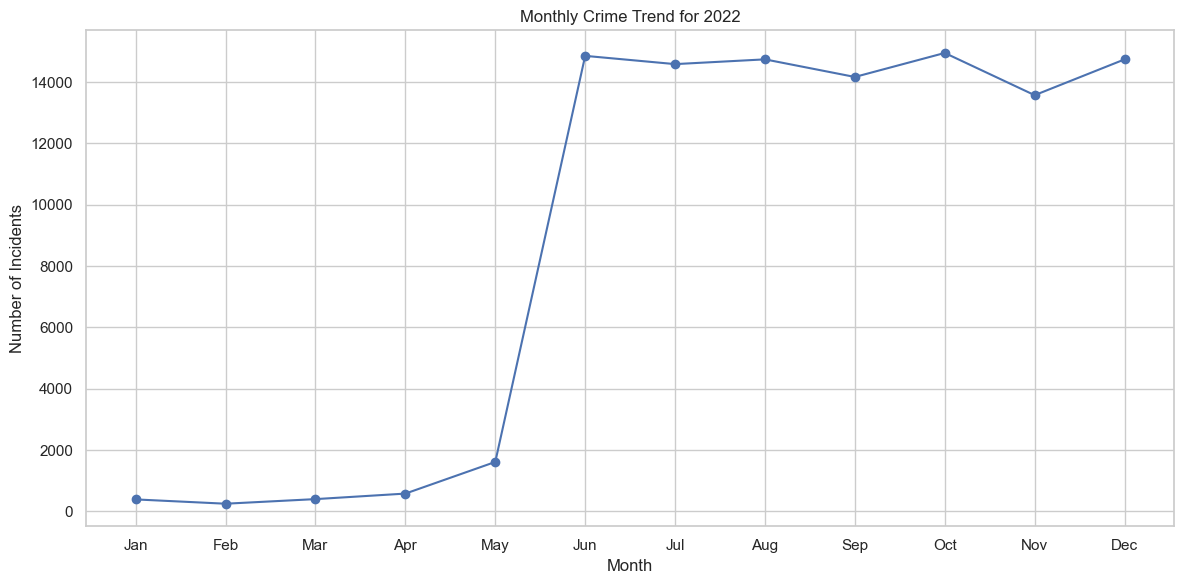

In [ ]:
# Determine the year to analyze
latest_year = df['Year'].max()
# We analyze the year before the latest year to ensure we have a full 12 months of data
analysis_year = latest_year - 1

df_last_year = df[df['Year'] == analysis_year]
monthly_crime_counts = df_last_year.groupby('Month').size()

print(f"\nMonthly Crime Counts for {analysis_year}:")
print(monthly_crime_counts)

# Plotting the monthly crime trend
plt.figure(figsize=(12, 6))
monthly_crime_counts.plot(kind='line', marker='o', linestyle='-')
plt.title(f'Monthly Crime Trend for {analysis_year}')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()

 ## 3. Geospatial and Crime Type Analysis

 ### 3.1 Geospatial Distribution of All Crimes

 Here we plot all crime incidents on a map of Los Angeles to visualize hotspots.

In [ ]:
# Only run geospatial plots if LAT and LON columns were successfully created
if not df['LAT'].isnull().all():
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='LON', y='LAT', data=df, s=1, alpha=0.1, color='red')
    plt.title('Geospatial Distribution of All Crimes in LA')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping geospatial distribution plot as LAT/LON data is unavailable.")


Skipping geospatial distribution plot as LAT/LON data is unavailable.


 ### 3.2 Analysis of Top Crime Types

 Let's identify the most common types of crime and visualize their distribution.


Top 10 Most Common Crimes:
Crm Cd Desc
THEFT OF IDENTITY                                           22670
BATTERY - SIMPLE ASSAULT                                    19694
BURGLARY FROM VEHICLE                                       13799
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              13215
INTIMATE PARTNER - SIMPLE ASSAULT                           11981
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)         11484
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     10719
THEFT PLAIN - PETTY ($950 & UNDER)                          10603
BURGLARY                                                    10268
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     7057
Name: count, dtype: int64


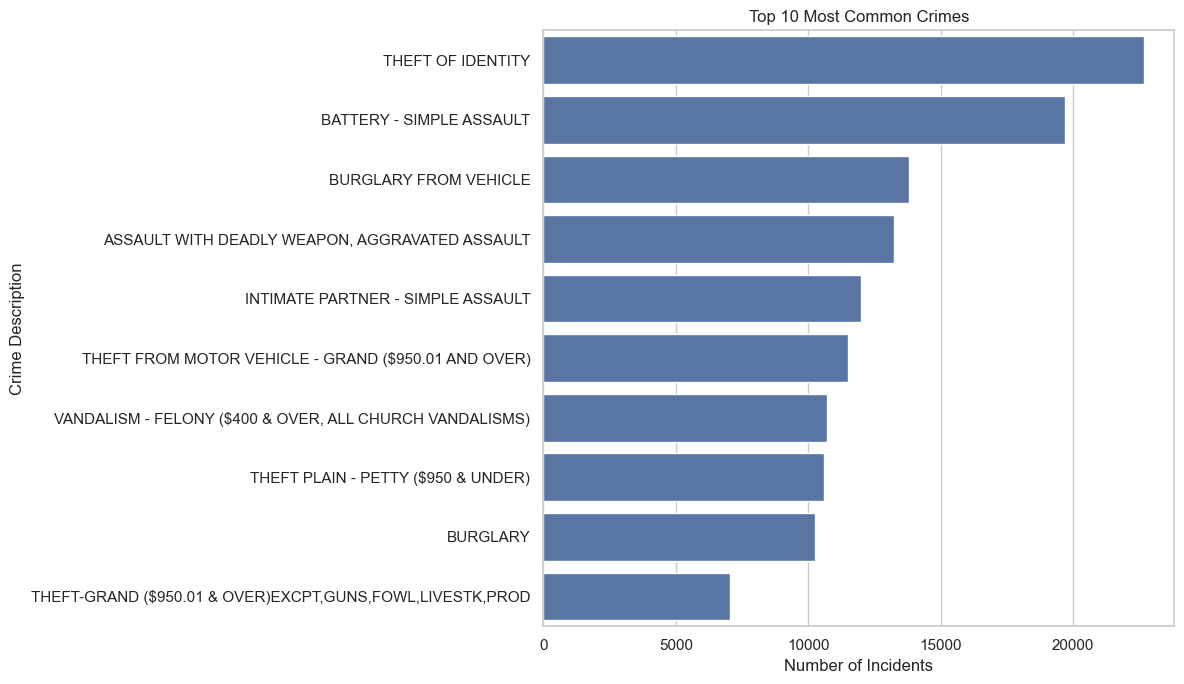

In [ ]:
top_10_crimes = df['Crm Cd Desc'].value_counts().nlargest(10)

print("\nTop 10 Most Common Crimes:")
print(top_10_crimes)

plt.figure(figsize=(12, 7))
sns.barplot(y=top_10_crimes.index, x=top_10_crimes.values, orient='h')
plt.title('Top 10 Most Common Crimes')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Description')
plt.tight_layout()
plt.show()

 ### 3.3 Geospatial Plot of a Specific Crime

 To get a more focused view, let's plot the locations of the most common crime: **Vehicle Stolen**.

In [ ]:
if not df['LAT'].isnull().all():
    most_common_crime = top_10_crimes.index[0]
    df_specific_crime = df[df['Crm Cd Desc'] == most_common_crime]

    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='LON', y='LAT', data=df_specific_crime, s=5, alpha=0.2)
    plt.title(f'Geospatial Distribution of: {most_common_crime}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping specific crime geospatial plot as LAT/LON data is unavailable.")


Skipping specific crime geospatial plot as LAT/LON data is unavailable.
